In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cross_validation import train_test_split
from scipy.optimize import minimize
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical

/Users/abhavluthra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
cd '/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/HumanObserved-Dataset/HumanObserved-Features-Data'

/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/HumanObserved-Dataset/HumanObserved-Features-Data


In [3]:
pwd

'/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/HumanObserved-Dataset/HumanObserved-Features-Data'

In [4]:
diff_filepath = "diffn_pairs.csv"
same_filepath = "same_pairs.csv"
feature_filepath = "HumanObserved-Features-Data.csv"

#Read All The Files
diff_pair = pd.read_csv(diff_filepath)
same_pair = pd.read_csv(same_filepath)            
train_features = pd.read_csv(feature_filepath)

diff_rand_pair, diff_rest = train_test_split(diff_pair, test_size=0.9973, random_state=1)

## merging samepair and diffpair files
output = pd.DataFrame.append(diff_rand_pair, same_pair)

## mearging features for img_id_A
merge_output = pd.merge(output, train_features, how='left', left_on='img_id_A', right_on='img_id')  ##merging feature file wrt 
merge_output.drop(columns = ['Unnamed: 0', 'img_id'], axis =1, inplace = True)    

## mearging features for img_id_B
merge_output = pd.merge(merge_output, train_features, how='left', left_on='img_id_B', right_on='img_id')
merge_output.drop(columns = ['Unnamed: 0', 'img_id'], axis =1, inplace = True)

## Concatenated Data
final_feature_cat = merge_output.loc[:, ['f1_x', 'f2_x', 'f3_x', 'f4_x',
       'f5_x', 'f6_x', 'f7_x', 'f8_x', 'f9_x', 'f1_y', 'f2_y', 'f3_y',
       'f4_y', 'f5_y', 'f6_y', 'f7_y', 'f8_y', 'f9_y']]

final_feature_cat.columns.values

array(['f1_x', 'f2_x', 'f3_x', 'f4_x', 'f5_x', 'f6_x', 'f7_x', 'f8_x',
       'f9_x', 'f1_y', 'f2_y', 'f3_y', 'f4_y', 'f5_y', 'f6_y', 'f7_y',
       'f8_y', 'f9_y'], dtype=object)

In [5]:
# Subtracting Feature of img_id_A - img_id_B
merge_output['f1_x'] = abs(merge_output['f1_x'] - merge_output['f1_y'])
merge_output['f2_x'] = abs(merge_output['f2_x'] - merge_output['f2_y'])
merge_output['f3_x'] = abs(merge_output['f3_x'] - merge_output['f3_y'])
merge_output['f4_x'] = abs(merge_output['f4_x'] - merge_output['f4_y'])
merge_output['f5_x'] = abs(merge_output['f5_x'] - merge_output['f5_y'])
merge_output['f6_x'] = abs(merge_output['f6_x'] - merge_output['f6_y'])
merge_output['f7_x'] = abs(merge_output['f7_x'] - merge_output['f7_y'])
merge_output['f8_x'] = abs(merge_output['f8_x'] - merge_output['f8_y'])
merge_output['f9_x'] = abs(merge_output['f9_x'] - merge_output['f9_y'])

In [6]:
# subtracted Data set
final_feature_sub = merge_output.loc[:, ['f1_x', 'f2_x', 'f3_x', 'f4_x','f5_x', 'f6_x', 'f7_x', 'f8_x', 'f9_x']]
# y dataset
final_target = merge_output.loc[:, ['target']]

In [7]:
# converting to numpy
final_target1 = final_target.values
final_feature_sub = final_feature_sub.values
final_feature_cat = final_feature_cat.values

Linear Regression

1. DataSet For Subtraction

In [8]:
# 80-10-10 data split
x_train, x_test, y_train, y_test = train_test_split(final_feature_sub, final_target1, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=1)
y_train.shape

(1265, 1)

In [32]:
# calculate BigSigma- Its only dependent on training data
#-------------------------------------------------------
BigSigma = np.zeros((x_train.shape[1],x_train.shape[1]))

varVect  = []
x_trainT = np.transpose(x_train)

for i in range(0,x_train.shape[1]):
    vct = []
    for j in range(0,len(x_train)):
        vct.append(x_trainT[i][j])    
    varVect.append(np.var(vct))

for i in range(x_train.shape[1]):
        BigSigma[i][i] = varVect[i]
        
BigSigma = np.dot(200,BigSigma)
#-------------------------------------------------------
print("BigSigma shape is", BigSigma.shape)

BigSigma shape is (9, 9)


In [19]:
# calculate K means
def KmeansCluster(n_clusters, x_train):
    kmeans = KMeans(n_clusters)
    # Fitting
    kmeans = kmeans.fit(x_train)
    # Centroid values
    centroids = kmeans.cluster_centers_
    return centroids

# now calculate Phi

def GetScalar(DataRow,MuRow, BigSigInv):  # To calculate the exponential term in basis function.
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def CalculatePhi(Data, Mu, BigSigma): # determine phi matrix value
    DataT = np.transpose(Data)
    Phi = np.zeros((int(DataT.shape[1]),len(Mu))) 
    BigSigInv = np.linalg.inv(BigSigma)
    
    for i in range(0,len(Mu)):
        for j in range(0,int(DataT.shape[1])):
            Phi[j][i] = math.exp(-0.5 * GetScalar(Data[j],Mu[i],BigSigInv))
    return Phi

# return target value used for validation and testing
def GetValTest(Phi,W):
    Y = np.dot(Phi, W)
    return Y

# returns accuracy and root mean square of the dataset given
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]): # check no of correctly predicted values
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT))) #accuracy = no of correctly predicted / total predicted
    
    erms =  np.sqrt(np.mean((ValDataAct - VAL_TEST_OUT)**2))
    return (str(accuracy) + ',' +  str(erms)) # return accuracy and erms

In [10]:
n_clusters = 6

centroids = KmeansCluster(n_clusters,x_train)
Phi_train = CalculatePhi(x_train, centroids, BigSigma)
Phi_Val = CalculatePhi(x_val, centroids, BigSigma)
Phi_Test = CalculatePhi(x_test, centroids, BigSigma)

In [11]:
# initialize weights randomly
W_Now = np.random.rand(6,) 
#print(W_Now.shape)
La           = 0.05
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []

y_train = np.reshape(y_train, (1265,))  

ErmsVal   = []
ErmsTR    = []
ErmsTest  = []
AccVal   = []
AccTR    = []
AccTest  = []


learningRate = [0.001,0.01, 0.05,0.1,0.15,0.2,0.3]
for j in range(0,7):
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    for i in range(0,400):

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((y_train[i] - np.dot(np.transpose(W_Now),Phi_train[i])),Phi_train[i]) # weights updated
        La_Delta_E_W  = np.dot(La,W_Now) # SCALING
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
        Delta_W       = -np.dot(learningRate[j],Delta_E) # learning quotient
        W_T_Next      = W_Now + Delta_W # after single iteration - updated weight
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(Phi_train,W_T_Next) # predicted t for training data
        Erms_TR       = GetErms(TR_TEST_OUT,y_train)
        L_Erms_TR.append(float(Erms_TR.split(',')[1])) #erms
        L_Acc_TR.append(float(Erms_TR.split(',')[0]))  #Accuracy

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(Phi_Val,W_T_Next) # predicted t for Validation data
        Erms_Val      = GetErms(VAL_TEST_OUT,y_val)
        L_Erms_Val.append(float(Erms_Val.split(',')[1])) #erms
        L_Acc_Val.append(float(Erms_Val.split(',')[0]))  #Accuracy

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(Phi_Test,W_T_Next) # predicted t for Testing data
        Erms_Test = GetErms(TEST_OUT,y_test)
        L_Erms_Test.append(float(Erms_Test.split(',')[1])) #erms
        L_Acc_Test.append(float(Erms_Test.split(',')[0]))  #Accuracy
    
    ErmsTR.append(np.around(min(L_Erms_TR),5))
    AccTR.append(np.around(max(L_Acc_TR),5))
    ErmsVal.append(np.around(min(L_Erms_Val),5))
    AccVal.append(np.around(max(L_Acc_Val),5))
    ErmsTest.append(np.around(min(L_Erms_Test),5))
    AccTest.append(np.around(max(L_Acc_Test),5))

In [12]:
print ('----------Gradient Descent Solution--------------------')
for i in range(0,7):
    print ("Learning Rate : " + str(learningRate[i]))
    print ("E_rms Training for loop " + str(i) +": " + str(ErmsTR[i]))
    print ("E_rms Validation for loop " + str(i) +": " + str(ErmsVal[i]))
    print ("E_rms Testing for loop " + str(i) +": " + str(ErmsTest[i]))
    print ("Acc Training for loop " + str(i) +": " + str(AccTR[i]))
    print ("Acc Validation for loop " + str(i) +": " + str(AccVal[i]))
    print ("Acc Testing for loop " + str(i) +": " + str(AccTest[i]))

----------Gradient Descent Solution--------------------
Learning Rate : 0.001
E_rms Training for loop 0: 0.54869
E_rms Validation for loop 0: 0.55075
E_rms Testing for loop 0: 0.56536
Acc Training for loop 0: 50.43478
Acc Validation for loop 0: 50.0
Acc Testing for loop 0: 46.54088
Learning Rate : 0.01
E_rms Training for loop 1: 0.49998
E_rms Validation for loop 1: 0.50006
E_rms Testing for loop 1: 0.49886
Acc Training for loop 1: 52.01581
Acc Validation for loop 1: 52.53165
Acc Testing for loop 1: 57.2327
Learning Rate : 0.05
E_rms Training for loop 2: 0.49985
E_rms Validation for loop 2: 0.50003
E_rms Testing for loop 2: 0.49883
Acc Training for loop 2: 53.04348
Acc Validation for loop 2: 53.79747
Acc Testing for loop 2: 55.97484
Learning Rate : 0.1
E_rms Training for loop 3: 0.50256
E_rms Validation for loop 3: 0.50332
E_rms Testing for loop 3: 0.49974
Acc Training for loop 3: 50.43478
Acc Validation for loop 3: 50.0
Acc Testing for loop 3: 53.45912
Learning Rate : 0.15
E_rms Traini

In [13]:
ErmsTRPlot = ErmsTR.pop()
ErmsValPlot = ErmsVal.pop()
ErmsTestPlot = ErmsTest.pop()

AccTRPlot = AccTR.pop()
AccValPlot = AccVal.pop()
AccTestPlot = AccTest.pop()
learningRate.pop()
print(ErmsTRPlot)

0.49974


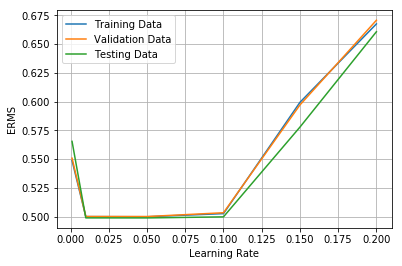

In [14]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, ErmsTR, label='Training Data')
line2, = ax.plot(learningRate, ErmsVal, label='Validation Data')
line3, = ax.plot(learningRate, ErmsTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

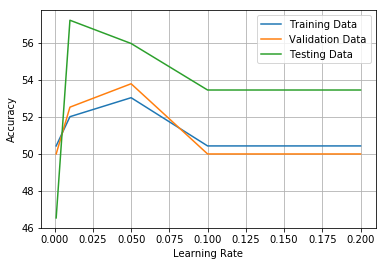

In [15]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, AccTR, label='Training Data')
line2, = ax.plot(learningRate, AccVal, label='Validation Data')
line3, = ax.plot(learningRate, AccTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

Logistic Regression

In [9]:
def Sigmoid(genesis):
    return 1 / (1 + np.exp(-genesis))

# cost function with reglurization
def cost(W, X, y, learningRate):
    W = np.matrix(W)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(Sigmoid(X * W.T)))
    second = np.multiply((1 - y), np.log(1 - Sigmoid(X * W.T)))
    
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(W[:,1:W.shape[1]], 2))
    
    return np.sum(first - second) / (len(X)) + reg

# vectorized Gradient Descent
def gradient(W, X, y, learningRate):
    W = np.matrix(W)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(W.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = Sigmoid(X * W.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * W[:,i])
    
    return grad

def predict_all(X, all_W):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_W.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    X = np.matrix(X)
    all_W = np.matrix(all_W)
    
    # probability for each feature on each training instance
    h = Sigmoid(X * all_W.T)
    
    # array of maximum probability
    h_argmax = np.round(h)
    
    # converting to single column array
    h_argmax = np.argmax(h_argmax, axis=1) 
    
    return h_argmax

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_W = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        W = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the cost function
        fmin = minimize(fun=cost, x0=W, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_W[i-1,:] = fmin.x
    
    return all_W

In [11]:
all_W = one_vs_all(x_train, y_train, 9, 1)

In [12]:
y_pred = predict_all(x_train, all_W)
y_pred.shape

(1265, 1)

In [13]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_train)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for training = {0}%'.format(accuracy * 100))

accuracy for training = 49.56521739130435%


In [14]:
y_pred = predict_all(x_test, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_test)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for testing = {0}%'.format(accuracy * 100))

accuracy for testing = 53.459119496855344%


In [15]:
y_pred = predict_all(x_val, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_val)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for validation = {0}%'.format(accuracy * 100))

accuracy for validation = 50.0%


Neural Network

In [23]:
input_size = 9
drop_out = 0.2
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 2

def get_model():
    
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))

    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('softmax'))
    
    model.summary()

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2560      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 3,074
Trainable params: 3,074
Non-trainable params: 0
_________________________________________________________________


In [25]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer().fit(final_feature_sub)
X = normalizer.transform(final_feature_sub)

validation_data_split = 0.2
num_epochs = 1000
model_batch_size = 64
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')


# Process Dataset
processedData = X
#processedLabel = encodeLabel(final_target)
processedLabel = to_categorical(final_target)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 1265 samples, validate on 317 samples
Epoch 1/1000
1265/1265 [==============================] - 0s 330us/step - loss: 0.6654 - acc: 0.6111 - val_loss: 0.9775 - val_acc: 0.0000e+00
Epoch 2/1000
1265/1265 [==============================] - 0s 122us/step - loss: 0.6484 - acc: 0.6253 - val_loss: 1.1176 - val_acc: 0.0000e+00
Epoch 3/1000
1265/1265 [==============================] - 0s 124us/step - loss: 0.6417 - acc: 0.6237 - val_loss: 1.0705 - val_acc: 0.0000e+00
Epoch 4/1000
1265/1265 [==============================] - 0s 131us/step - loss: 0.6360 - acc: 0.6387 - val_loss: 1.1227 - val_acc: 0.0000e+00
Epoch 5/1000
1265/1265 [==============================] - 0s 150us/step - loss: 0.6345 - acc: 0.6379 - val_loss: 1.1266 - val_acc: 0.0095
Epoch 6/1000
1265/1265 [==============================] - 0s 129us/step - loss: 0.6302 - acc: 0.6364 - val_loss: 1.1317 - val_acc: 0.0158
Epoch 7/1000
1265/1265 [==============================] - 0s 117us/step - loss: 0.6300 - acc: 0.6545 - val_lo

1265/1265 [==============================] - 0s 110us/step - loss: 0.5938 - acc: 0.6870 - val_loss: 1.3468 - val_acc: 0.0505
Epoch 60/1000
1265/1265 [==============================] - 0s 113us/step - loss: 0.5930 - acc: 0.6862 - val_loss: 1.3236 - val_acc: 0.0726
Epoch 61/1000
1265/1265 [==============================] - 0s 110us/step - loss: 0.5912 - acc: 0.6672 - val_loss: 1.4281 - val_acc: 0.0410
Epoch 62/1000
1265/1265 [==============================] - 0s 131us/step - loss: 0.5909 - acc: 0.6767 - val_loss: 1.3488 - val_acc: 0.0568
Epoch 63/1000
1265/1265 [==============================] - 0s 155us/step - loss: 0.5932 - acc: 0.6775 - val_loss: 1.3320 - val_acc: 0.0536
Epoch 64/1000
1265/1265 [==============================] - 0s 127us/step - loss: 0.5936 - acc: 0.6696 - val_loss: 1.3175 - val_acc: 0.0662
Epoch 65/1000
1265/1265 [==============================] - 0s 118us/step - loss: 0.5939 - acc: 0.6838 - val_loss: 1.3245 - val_acc: 0.0568
Epoch 66/1000
1265/1265 [================

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2393c908>,
      dtype=object)

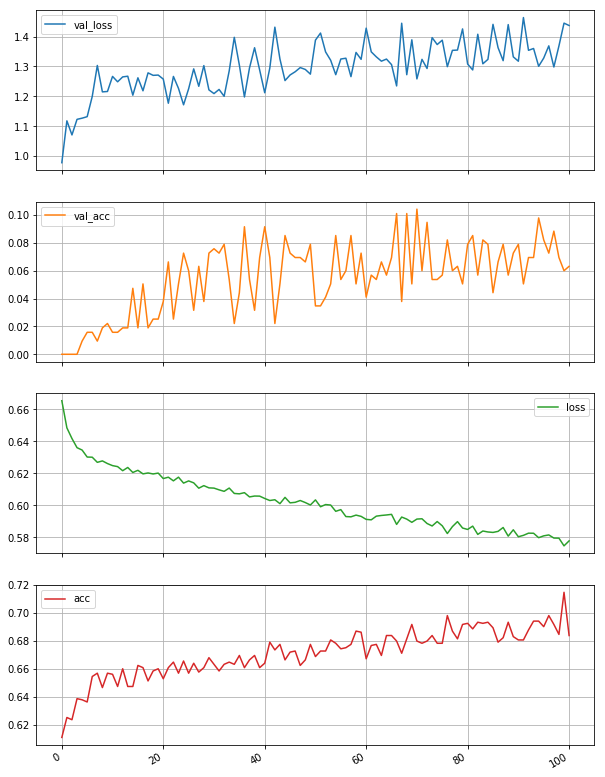

In [26]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [27]:
right = 0
wrong = 0
predictedTestLabel = []
for i,j in zip(final_feature_sub,final_target):
    y = model.predict(np.array(i).reshape(-1,9))
    predictedTestLabel.append(y.round())
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1
        
print("Testing Accuracy: " + str(right/(right+wrong)*100))

Testing Accuracy: 89.50695322376738


2. DataSet For Concatenation

In [16]:
x_train, x_test, y_train, y_test = train_test_split(final_feature_cat, final_target1, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=1)
y_train.shape

(1265, 1)

In [17]:
# calculate BigSigma- Its only dependent on training data
#-------------------------------------------------------
BigSigma = np.zeros((x_train.shape[1],x_train.shape[1]))

varVect  = []
x_trainT = np.transpose(x_train)

for i in range(0,x_train.shape[1]):
    vct = []
    for j in range(0,len(x_train)):
        vct.append(x_trainT[i][j])    
    varVect.append(np.var(vct))

for i in range(x_train.shape[1]):
        BigSigma[i][i] = varVect[i]
        
BigSigma = np.dot(200,BigSigma)
#-------------------------------------------------------
print("BigSigma shape is", BigSigma.shape)

BigSigma shape is (18, 18)


In [20]:
n_clusters = 6

centroids = KmeansCluster(n_clusters, x_train)
Phi_train = CalculatePhi(x_train, centroids, BigSigma)
Phi_Val = CalculatePhi(x_val, centroids, BigSigma)
Phi_Test = CalculatePhi(x_test, centroids, BigSigma)

In [21]:
# initialize weights randomly
W_Now = np.random.rand(6,) 
#print(W_Now.shape)
La           = 1
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []

y_train = np.reshape(y_train, (1265,))  

ErmsVal   = []
ErmsTR    = []
ErmsTest  = []
AccVal   = []
AccTR    = []
AccTest  = []


learningRate = [0.001,0.01, 0.05,0.1,0.15,0.2,0.3]
for j in range(0,7):
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    for i in range(0,400):

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((y_train[i] - np.dot(np.transpose(W_Now),Phi_train[i])),Phi_train[i]) # weights updated
        La_Delta_E_W  = np.dot(La,W_Now) # SCALING
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
        Delta_W       = -np.dot(learningRate[j],Delta_E) # learning quotient
        W_T_Next      = W_Now + Delta_W # after single iteration - updated weight
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(Phi_train,W_T_Next) # predicted t for training data
        Erms_TR       = GetErms(TR_TEST_OUT,y_train)
        L_Erms_TR.append(float(Erms_TR.split(',')[1])) #erms
        L_Acc_TR.append(float(Erms_TR.split(',')[0]))  #Accuracy

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(Phi_Val,W_T_Next) # predicted t for Validation data
        Erms_Val      = GetErms(VAL_TEST_OUT,y_val)
        L_Erms_Val.append(float(Erms_Val.split(',')[1])) #erms
        L_Acc_Val.append(float(Erms_Val.split(',')[0]))  #Accuracy

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(Phi_Test,W_T_Next) # predicted t for Testing data
        Erms_Test = GetErms(TEST_OUT,y_test)
        L_Erms_Test.append(float(Erms_Test.split(',')[1])) #erms
        L_Acc_Test.append(float(Erms_Test.split(',')[0]))  #Accuracy
    
    ErmsTR.append(np.around(min(L_Erms_TR),5))
    AccTR.append(np.around(max(L_Acc_TR),5))
    ErmsVal.append(np.around(min(L_Erms_Val),5))
    AccVal.append(np.around(max(L_Acc_Val),5))
    ErmsTest.append(np.around(min(L_Erms_Test),5))
    AccTest.append(np.around(max(L_Acc_Test),5))

In [22]:
print ('----------Gradient Descent Solution--------------------')
for i in range(0,7):
    print ("Learning Rate : " + str(learningRate[i]))
    print ("E_rms Training for loop " + str(i) +": " + str(ErmsTR[i]))
    print ("E_rms Validation for loop " + str(i) +": " + str(ErmsVal[i]))
    print ("E_rms Testing for loop " + str(i) +": " + str(ErmsTest[i]))
    print ("Acc Training for loop " + str(i) +": " + str(AccTR[i]))
    print ("Acc Validation for loop " + str(i) +": " + str(AccVal[i]))
    print ("Acc Testing for loop " + str(i) +": " + str(AccTest[i]))

----------Gradient Descent Solution--------------------
Learning Rate : 0.001
E_rms Training for loop 0: 0.51444
E_rms Validation for loop 0: 0.5158
E_rms Testing for loop 0: 0.52437
Acc Training for loop 0: 50.43478
Acc Validation for loop 0: 50.0
Acc Testing for loop 0: 46.54088
Learning Rate : 0.01
E_rms Training for loop 1: 0.49973
E_rms Validation for loop 1: 0.50008
E_rms Testing for loop 1: 0.49886
Acc Training for loop 1: 54.3083
Acc Validation for loop 1: 55.6962
Acc Testing for loop 1: 55.34591
Learning Rate : 0.05
E_rms Training for loop 2: 0.49973
E_rms Validation for loop 2: 0.50008
E_rms Testing for loop 2: 0.49886
Acc Training for loop 2: 54.22925
Acc Validation for loop 2: 55.06329
Acc Testing for loop 2: 54.71698
Learning Rate : 0.1
E_rms Training for loop 3: 0.50024
E_rms Validation for loop 3: 0.50081
E_rms Testing for loop 3: 0.50273
Acc Training for loop 3: 50.43478
Acc Validation for loop 3: 50.63291
Acc Testing for loop 3: 53.45912
Learning Rate : 0.15
E_rms Trai

In [23]:
ErmsTRPlot = ErmsTR.pop()
ErmsValPlot = ErmsVal.pop()
ErmsTestPlot = ErmsTest.pop()

AccTRPlot = AccTR.pop()
AccValPlot = AccVal.pop()
AccTestPlot = AccTest.pop()
learningRate.pop()

0.3

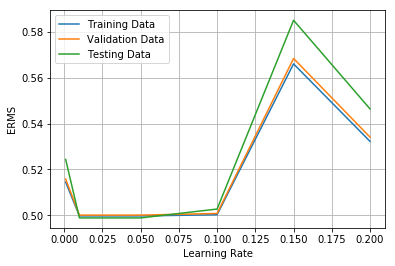

In [24]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, ErmsTR, label='Training Data')
line2, = ax.plot(learningRate, ErmsVal, label='Validation Data')
line3, = ax.plot(learningRate, ErmsTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

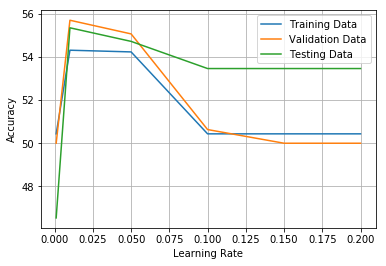

In [25]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, AccTR, label='Training Data')
line2, = ax.plot(learningRate, AccVal, label='Validation Data')
line3, = ax.plot(learningRate, AccTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

Logistic Regression

In [26]:
all_W = one_vs_all(x_train, y_train, 18, 1)

In [27]:
y_pred = predict_all(x_train, all_W)
y_pred.shape

(1265, 1)

In [28]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_train)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for training = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_test, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_test)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for testing = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_val, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_val)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for validation = {0}%'.format(accuracy * 100))

accuracy for training = 49.56521739130435%
accuracy for testing = 53.459119496855344%
accuracy for validation = 50.0%


Neural Network

In [76]:
input_size = 18
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer_nodes = 2

model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               9728      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_14 (Activation)   (None, 2)                 0         
Total params: 10,754
Trainable params: 10,754
Non-trainable params: 0
_________________________________________________________________


In [77]:
#normalizer = preprocessing.Normalizer().fit(final_feature_cat)
#X = normalizer.transform(final_feature_cat)

validation_data_split = 0.2
num_epochs = 1000
model_batch_size = 64
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

processedData = final_feature_cat
processedLabel = to_categorical(final_target1)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 1265 samples, validate on 317 samples
Epoch 1/1000
1265/1265 [==============================] - 1s 519us/step - loss: 0.6792 - acc: 0.5937 - val_loss: 1.1323 - val_acc: 0.0631
Epoch 2/1000
1265/1265 [==============================] - 0s 232us/step - loss: 0.6381 - acc: 0.6174 - val_loss: 1.7032 - val_acc: 0.0000e+00
Epoch 3/1000
1265/1265 [==============================] - 0s 198us/step - loss: 0.6219 - acc: 0.6451 - val_loss: 1.8315 - val_acc: 0.0000e+00
Epoch 4/1000
1265/1265 [==============================] - 0s 200us/step - loss: 0.6271 - acc: 0.6332 - val_loss: 0.9725 - val_acc: 0.3155
Epoch 5/1000
1265/1265 [==============================] - 0s 234us/step - loss: 0.6259 - acc: 0.6458 - val_loss: 2.0489 - val_acc: 0.0000e+00
Epoch 6/1000
1265/1265 [==============================] - 0s 212us/step - loss: 0.6098 - acc: 0.6632 - val_loss: 1.3635 - val_acc: 0.0883
Epoch 7/1000
1265/1265 [==============================] - 0s 237us/step - loss: 0.6180 - acc: 0.6514 - val_loss: 

1265/1265 [==============================] - 0s 214us/step - loss: 0.4523 - acc: 0.7787 - val_loss: 2.1563 - val_acc: 0.1388
Epoch 60/1000
1265/1265 [==============================] - 0s 204us/step - loss: 0.4328 - acc: 0.7992 - val_loss: 3.0556 - val_acc: 0.0315
Epoch 61/1000
1265/1265 [==============================] - 0s 218us/step - loss: 0.4505 - acc: 0.7747 - val_loss: 2.3160 - val_acc: 0.1104
Epoch 62/1000
1265/1265 [==============================] - 0s 191us/step - loss: 0.4429 - acc: 0.7794 - val_loss: 2.7876 - val_acc: 0.0505
Epoch 63/1000
1265/1265 [==============================] - 0s 201us/step - loss: 0.4336 - acc: 0.7905 - val_loss: 3.1670 - val_acc: 0.0284
Epoch 64/1000
1265/1265 [==============================] - 0s 210us/step - loss: 0.4361 - acc: 0.7929 - val_loss: 2.3917 - val_acc: 0.0946
Epoch 65/1000
1265/1265 [==============================] - 0s 203us/step - loss: 0.4269 - acc: 0.8000 - val_loss: 2.3312 - val_acc: 0.1104
Epoch 66/1000
1265/1265 [================

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c357a1c18>,
      dtype=object)

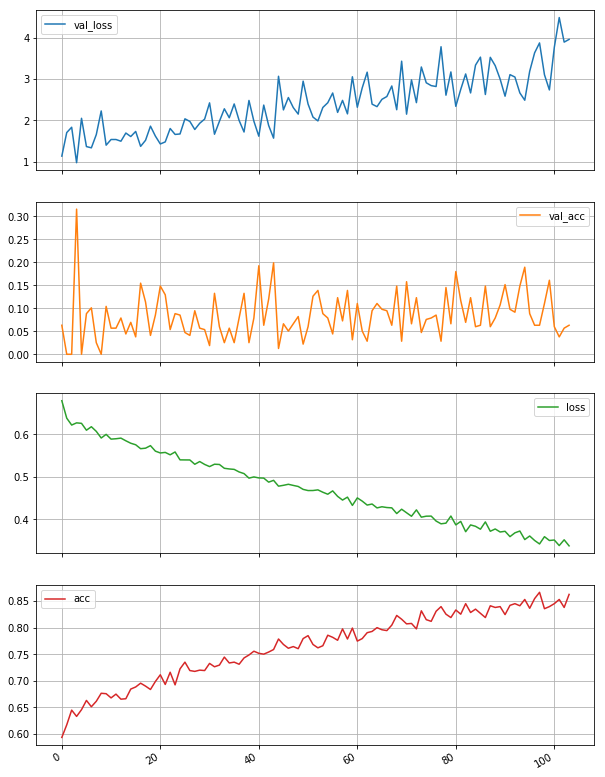

In [78]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [79]:
right = 0
wrong = 0
predictedTestLabel = []
for i,j in zip(final_feature_cat,final_target1):
    y = model.predict(np.array(i).reshape(-1,18))
    predictedTestLabel.append(y.round())
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1
        
print("Testing Accuracy: " + str(right/(right+wrong)*100))

Testing Accuracy: 78.57142857142857


Now Lets work on GSC DATASET

In [29]:
cd '/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/GSC-Dataset/GSC-Features-Data'

/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/GSC-Dataset/GSC-Features-Data


In [30]:
pwd

'/Users/abhavluthra/Desktop/ML-1_ST_SEM/Project2/GSC-Dataset/GSC-Features-Data'

In [31]:
diff_filepath = "diffn_pairs.csv"
same_filepath = "same_pairs.csv"
feature_filepath = "GSC-Features.csv"

diff_pair = pd.read_csv(diff_filepath)
same_pair = pd.read_csv(same_filepath)            
train_features = pd.read_csv(feature_filepath)
diff_pair.shape

diff_rand_pair, diff_rest = train_test_split(diff_pair, test_size=0.90619, random_state=1)


## merging samepair and diffpair files
output = pd.DataFrame.append(diff_rand_pair, same_pair)

merge_output = pd.merge(output, train_features, how='left', left_on='img_id_A', right_on='img_id')  ##merging feature file wrt 
merge_output.drop(columns = ['img_id'], axis =1, inplace = True)    

merge_output = pd.merge(merge_output, train_features, how='left', left_on='img_id_B', right_on='img_id')
merge_output.drop(columns = ['img_id'], axis =1, inplace = True)

In [32]:
final_feature_cat = merge_output.iloc[:, 3:] 
final_target = merge_output.loc[:, ['target']]

final_target = final_target.values
final_feature_cat = final_feature_cat.values

for i in range(0,512):
    merge_output['f'+ str(i+1) +'_x'] = abs(merge_output['f'+ str(i+1) +'_x'] - merge_output['f'+ str(i+1) +'_y'])

final_feature_sub = merge_output.iloc[:, 3:515]
final_feature_sub = final_feature_sub.values

In [33]:
final_feature_subT = final_feature_sub.transpose()
final_feature_subT.shape


p = []
for i in range(0,512):
    if np.var(final_feature_subT[i]) == float(0):
        p.append(i)
print(p)
final_feature_sub = np.delete(final_feature_sub, p, axis = 1)
final_feature_sub.shape

[450, 452, 456]


(143066, 509)

In [34]:
final_feature_catT = final_feature_cat.transpose()

c = []
for i in range(0,1024):
    if np.var(final_feature_catT[i]) == float(0):
        c.append(i)
print(c)
final_feature_cat = np.delete(final_feature_cat, p, axis = 1)
final_feature_cat.shape

[450, 452, 456, 457, 962, 964, 968]


(143066, 1021)

1. DataSet For Subtraction

Linear Regression

In [35]:
x_train, x_test, y_train, y_test = train_test_split(final_feature_sub, final_target, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=1)
y_train.shape

(114466, 1)

In [36]:
# calculate BigSigma- Its only dependent on training data
#-------------------------------------------------------
BigSigma = np.zeros((x_train.shape[1],x_train.shape[1]))

varVect  = []
x_trainT = np.transpose(x_train)

for i in range(0,x_train.shape[1]):
    vct = []
    for j in range(0,len(x_train)):
        vct.append(x_trainT[i][j])    
    varVect.append(np.var(vct))

for i in range(x_train.shape[1]):
        BigSigma[i][i] = varVect[i]
        
BigSigma = np.dot(200,BigSigma)
#-------------------------------------------------------
print("BigSigma shape is", BigSigma.shape)

BigSigma shape is (509, 509)


In [151]:
n_clusters = 10

centroids = KmeansCluster(n_clusters, x_train)
print('Centroid Done')
Phi_train = CalculatePhi(x_train, centroids, BigSigma)
print('Phi_train Done')
Phi_Val = CalculatePhi(x_val, centroids, BigSigma)
print('Phi_Val Done')
Phi_Test = CalculatePhi(x_test, centroids, BigSigma)
print('Phi_Test Done')

Centroid Done
Phi_train Done
Phi_Val Done
Phi_Test Done


In [ ]:
# initialize weights randomly
W_Now = np.random.rand(10,) 
#print(W_Now.shape)
La           = 0.005
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []

y_train = np.reshape(y_train, (114466,))  

ErmsVal   = []
ErmsTR    = []
ErmsTest  = []
AccVal   = []
AccTR    = []
AccTest  = []


learningRate = [0.001,0.005, 0.01, 0.05, 0.1, 0.5]
for j in range(0,6):
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    for i in range(0,400):

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((y_train[i] - np.dot(np.transpose(W_Now),Phi_train[i])),Phi_train[i]) # weights updated
        La_Delta_E_W  = np.dot(La,W_Now) # SCALING
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
        Delta_W       = -np.dot(learningRate[j],Delta_E) # learning quotient
        W_T_Next      = W_Now + Delta_W # after single iteration - updated weight
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(Phi_train,W_T_Next) # predicted t for training data
        Erms_TR       = GetErms(TR_TEST_OUT,y_train)
        L_Erms_TR.append(float(Erms_TR.split(',')[1])) #erms
        L_Acc_TR.append(float(Erms_TR.split(',')[0]))  #Accuracy

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(Phi_Val,W_T_Next) # predicted t for Validation data
        Erms_Val      = GetErms(VAL_TEST_OUT,y_val)
        L_Erms_Val.append(float(Erms_Val.split(',')[1])) #erms
        L_Acc_Val.append(float(Erms_Val.split(',')[0]))  #Accuracy

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(Phi_Test,W_T_Next) # predicted t for Testing data
        Erms_Test = GetErms(TEST_OUT,y_test)
        L_Erms_Test.append(float(Erms_Test.split(',')[1])) #erms
        L_Acc_Test.append(float(Erms_Test.split(',')[0]))  #Accuracy
    print('Loop Complete')
    ErmsTR.append(np.around(min(L_Erms_TR),5))
    AccTR.append(np.around(max(L_Acc_TR),5))
    ErmsVal.append(np.around(min(L_Erms_Val),5))
    AccVal.append(np.around(max(L_Acc_Val),5))
    ErmsTest.append(np.around(min(L_Erms_Test),5))
    AccTest.append(np.around(max(L_Acc_Test),5))

Loop Complete 
Loop Complete
Loop Complete
Loop Complete
Loop Complete
Loop Complete

In [ ]:
print ('----------Gradient Descent Solution--------------------')
for i in range(0,6):
    print ("Learning Rate : " + str(learningRate[i]))
    print ("E_rms Training for loop " + str(i) +": " + str(ErmsTR[i]))
    print ("E_rms Validation for loop " + str(i) +": " + str(ErmsVal[i]))
    print ("E_rms Testing for loop " + str(i) +": " + str(ErmsTest[i]))
    print ("Acc Training for loop " + str(i) +": " + str(AccTR[i]))
    print ("Acc Validation for loop " + str(i) +": " + str(AccVal[i]))
    print ("Acc Testing for loop " + str(i) +": " + str(AccTest[i]))

----------Gradient Descent Solution--------------------
Learning Rate : 0.001
E_rms Training for loop 0: 0.79802
E_rms Validation for loop 0: 0.83672
E_rms Testing for loop 0: 0.83953
Acc Training for loop 0: 46.07394
Acc Validation for loop 0: 45.91758
Acc Testing for loop 0: 45.71888
Learning Rate : 0.005
E_rms Training for loop 1: 0.50276
E_rms Validation for loop 1: 0.53345
E_rms Testing for loop 1: 0.5337
Acc Training for loop 1: 55.93801
Acc Validation for loop 1: 55.15987
Acc Testing for loop 1: 56.15433
Learning Rate : 0.01
E_rms Training for loop 2: 0.49749
E_rms Validation for loop 2: 0.52425
E_rms Testing for loop 2: 0.52401
Acc Training for loop 2: 59.64216
Acc Validation for loop 2: 59.75652
Acc Testing for loop 2: 59.76096
Learning Rate : 0.05
E_rms Training for loop 3: 0.49459
E_rms Validation for loop 3: 0.52366
E_rms Testing for loop 3: 0.52345
Acc Training for loop 3: 61.21556
Acc Validation for loop 3: 61.27475
Acc Testing for loop 3: 61.52233
Learning Rate : 0.1
E_rms Training for loop 4: 0.49124
E_rms Validation for loop 4: 0.52429
E_rms Testing for loop 4: 0.52406
Acc Training for loop 4: 62.4561
Acc Validation for loop 4: 62.64605
Acc Testing for loop 4: 62.61271
Learning Rate : 0.5
E_rms Training for loop 5: 0.48387
E_rms Validation for loop 5: 0.52946
E_rms Testing for loop 5: 0.52926
Acc Training for loop 5: 64.26712
Acc Validation for loop 0: 64.38816
Acc Testing for loop 5: 64.11547

In [37]:
# remove while executing above code:

learningRate = [0.001,0.005, 0.01, 0.05, 0.1, 0.5]
ErmsTR = [0.79802, 0.50276, 0.49749,0.49459, 0.49124, 0.48387]
ErmsVal = [0.83672, 0.53345, 0.52425, 0.52366, 0.52429, 0.52946]
ErmsTest = [0.83953, 0.5337, 0.52401, 0.52345, 0.52406, 0.52926]
AccTR = [46.07394, 55.93801, 59.64216, 61.21556, 62.4561, 64.26712]
AccVal = [45.91758, 55.15987, 59.75652, 61.27475, 62.64605, 64.38816]
AccTest = [45.71888, 56.15433, 59.76096, 61.52233, 62.61271, 64.11547]

In [51]:
ErmsTRPlot = ErmsTR.pop()
ErmsValPlot = ErmsVal.pop()
ErmsTestPlot = ErmsTest.pop()

AccTRPlot = AccTR.pop()
AccValPlot = AccVal.pop()
AccTestPlot = AccTest.pop()
learningRate.pop()

0.5

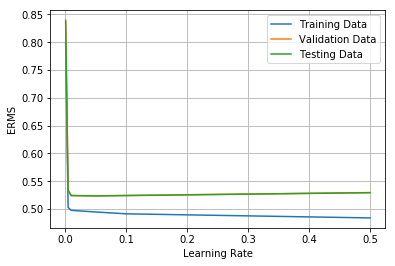

In [38]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, ErmsTR, label='Training Data')
line2, = ax.plot(learningRate, ErmsVal, label='Validation Data')
line3, = ax.plot(learningRate, ErmsTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

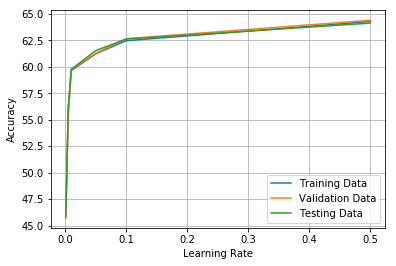

In [39]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, AccTR, label='Training Data')
line2, = ax.plot(learningRate, AccVal, label='Validation Data')
line3, = ax.plot(learningRate, AccTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

Logistic Regression

In [54]:
x_model, x_rest, y_model, y_rest = train_test_split(final_feature_sub, final_target, test_size=0.97, random_state=78)

# check for equal split
count = 0
for i in range(len(y_model)):
    if y_model[i] == 0:
        count = count + 1
print(count)
x_model.shape

x_trainR, x_testR, y_trainR, y_testR = train_test_split(x_model, y_model, test_size=0.1, random_state=1)
x_trainR, x_valR, y_trainR, y_valR = train_test_split(x_trainR, y_trainR, test_size=0.111, random_state=1)

x_trainR.shape

2085


(3432, 509)

In [55]:
x_valR.shape

(429, 509)

In [60]:
all_W = one_vs_all(x_trainR, y_trainR, 509, 1)
y_pred = predict_all(x_trainR, all_W)
y_pred.shape

(3432, 1)

In [61]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_trainR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for training = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_testR, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_testR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for testing = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_valR, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_valR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for validation = {0}%'.format(accuracy * 100))

accuracy for training = 48.33916083916084%
accuracy for testing = 49.53488372093023%
accuracy for validation = 49.65034965034965%


Neural Network

In [231]:
input_size = 509
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer_nodes = 2

model = get_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               261120    
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_16 (Activation)   (None, 2)                 0         
Total params: 262,146
Trainable params: 262,146
Non-trainable params: 0
_________________________________________________________________


In [250]:
x_model, x_rest, y_model, y_rest = train_test_split(final_feature_sub, final_target, test_size=0.9, random_state=78)

x_model.shape

(14306, 509)

In [257]:
count = 0
for i in range(len(y_model)):
    if y_model[i] == 0:
        count = count + 1
count

7053

In [258]:
normalizer = preprocessing.Normalizer().fit(x_model)
X = normalizer.transform(x_model)

validation_data_split = 0.2
num_epochs = 1000
model_batch_size = 256
tb_batch_size = 128
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

processedData = X
processedLabel = to_categorical(y_model)

In [259]:
processedLabel.shape

(14306, 2)

Train on 11444 samples, validate on 2862 samples
Epoch 1/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.3172 - acc: 0.8635 - val_loss: 0.3145 - val_acc: 0.8641
Epoch 2/1000
11444/11444 [==============================] - 11s 991us/step - loss: 0.2910 - acc: 0.8793 - val_loss: 0.3147 - val_acc: 0.8658
Epoch 3/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.2736 - acc: 0.8850 - val_loss: 0.3773 - val_acc: 0.8316
Epoch 4/1000
11444/11444 [==============================] - 13s 1ms/step - loss: 0.2538 - acc: 0.8992 - val_loss: 0.3184 - val_acc: 0.8616
Epoch 5/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.2397 - acc: 0.9089 - val_loss: 0.3237 - val_acc: 0.8581
Epoch 6/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.2235 - acc: 0.9135 - val_loss: 0.3542 - val_acc: 0.8491
Epoch 7/1000
11444/11444 [==============================] - 13s 1ms/step - loss: 0.2121 - acc: 0.9220 - val_loss: 0

11444/11444 [==============================] - 13s 1ms/step - loss: 0.0141 - acc: 0.9983 - val_loss: 0.6463 - val_acc: 0.8162
Epoch 60/1000
11444/11444 [==============================] - 13s 1ms/step - loss: 0.0122 - acc: 0.9987 - val_loss: 0.4986 - val_acc: 0.8449
Epoch 61/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.5239 - val_acc: 0.8435
Epoch 62/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.5181 - val_acc: 0.8442
Epoch 63/1000
11444/11444 [==============================] - 11s 1ms/step - loss: 0.0096 - acc: 0.9987 - val_loss: 0.5320 - val_acc: 0.8445
Epoch 64/1000
11444/11444 [==============================] - 12s 1ms/step - loss: 0.0101 - acc: 0.9989 - val_loss: 0.6527 - val_acc: 0.8120
Epoch 65/1000
11444/11444 [==============================] - 11s 1ms/step - loss: 0.0103 - acc: 0.9976 - val_loss: 0.5266 - val_acc: 0.8452
Epoch 66/1000
11444/11444 [=======

ValueError: cannot reshape array of size 1021 into shape (18)

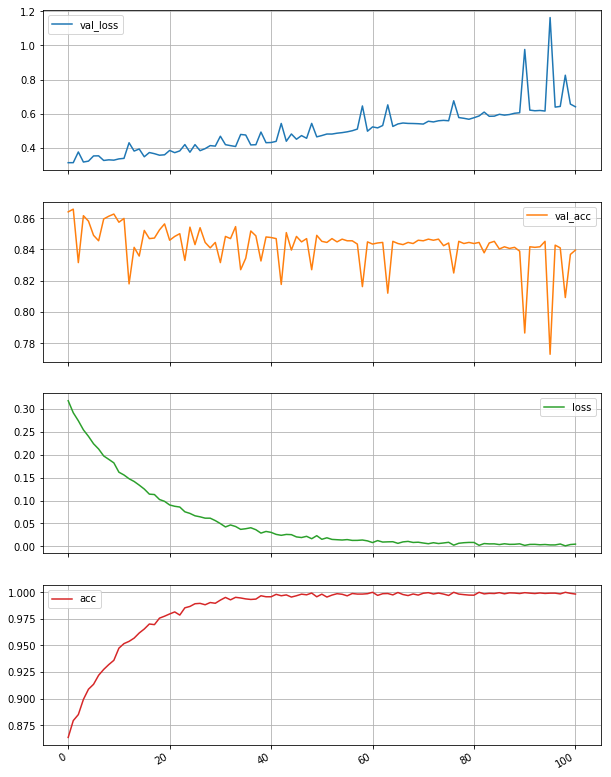

In [260]:
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



Testing Accuracy: 99.96504962952606


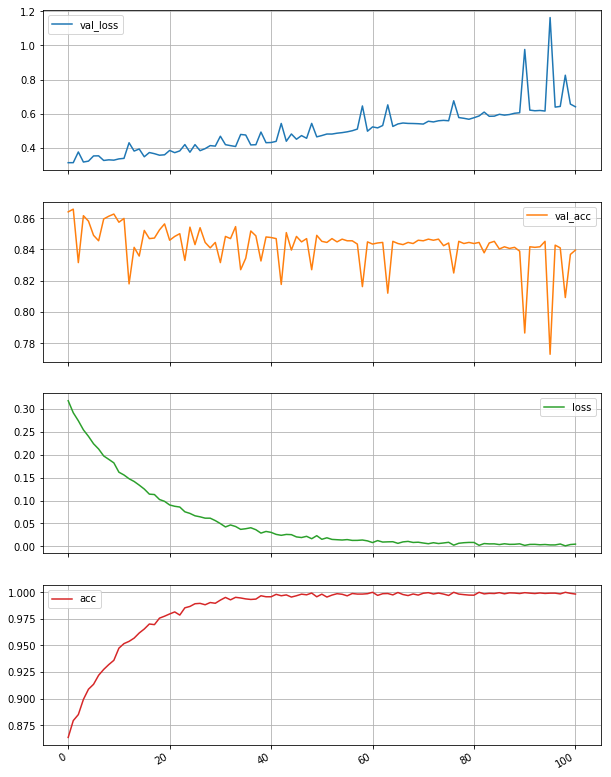

In [263]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

right = 0
wrong = 0
predictedTestLabel = []
for i,j in zip(x_model,y_model):
    y = model.predict(np.array(i).reshape(-1,509))
    predictedTestLabel.append(y.round())
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1
        
print("Testing Accuracy: " + str(right/(right+wrong)*100))

2. DataSet For Concatenation

In [62]:
x_train, x_test, y_train, y_test = train_test_split(final_feature_cat, final_target, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=1)
y_train.shape

(114466, 1)

In [63]:
# calculate BigSigma- Its only dependent on training data
#-------------------------------------------------------
BigSigma = np.zeros((x_train.shape[1],x_train.shape[1]))

varVect  = []
x_trainT = np.transpose(x_train)

for i in range(0,x_train.shape[1]):
    vct = []
    for j in range(0,len(x_train)):
        vct.append(x_trainT[i][j])    
    varVect.append(np.var(vct))

for i in range(x_train.shape[1]):
        BigSigma[i][i] = varVect[i]
        
BigSigma = np.dot(200,BigSigma)
#-------------------------------------------------------
print("BigSigma shape is", BigSigma.shape)

BigSigma shape is (1021, 1021)


In [65]:
def CalculatePhi(Data, Mu, BigSigma): # determine phi matrix value
    DataT = np.transpose(Data)
    Phi = np.zeros((int(DataT.shape[1]),len(Mu))) 
    BigSigInv = np.linalg.pinv(BigSigma)
    
    for i in range(0,len(Mu)):
        for j in range(0,int(DataT.shape[1])):
            Phi[j][i] = math.exp(-0.5 * GetScalar(Data[j],Mu[i],BigSigInv))
    return Phi

In [ ]:
n_clusters = 10

centroids = KmeansCluster(n_clusters, x_train)
print('Centroid Done')
Phi_train = CalculatePhi(x_train, centroids, BigSigma)
print('Phi_train Done')
Phi_Val = CalculatePhi(x_val, centroids, BigSigma)
print('Phi_Val Done')
Phi_Test = CalculatePhi(x_test, centroids, BigSigma)
print('Phi_Test Done')

In [ ]:
# initialize weights randomly
W_Now = np.random.rand(n_clusters,) 
#print(W_Now.shape)
La           = 1
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
L_Acc_Val   = []
L_Acc_TR    = []
L_Acc_Test  = []
W_Mat        = []

y_train = np.reshape(y_train, (1265,))  

ErmsVal   = []
ErmsTR    = []
ErmsTest  = []
AccVal   = []
AccTR    = []
AccTest  = []


learningRate = [0.001,0.01]
for j in range(0,2):
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    L_Acc_Val   = []
    L_Acc_TR    = []
    L_Acc_Test  = []
    for i in range(0,400):

        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((y_train[i] - np.dot(np.transpose(W_Now),Phi_train[i])),Phi_train[i]) # weights updated
        La_Delta_E_W  = np.dot(La,W_Now) # SCALING
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
        Delta_W       = -np.dot(learningRate[j],Delta_E) # learning quotient
        W_T_Next      = W_Now + Delta_W # after single iteration - updated weight
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(Phi_train,W_T_Next) # predicted t for training data
        Erms_TR       = GetErms(TR_TEST_OUT,y_train)
        L_Erms_TR.append(float(Erms_TR.split(',')[1])) #erms
        L_Acc_TR.append(float(Erms_TR.split(',')[0]))  #Accuracy

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(Phi_Val,W_T_Next) # predicted t for Validation data
        Erms_Val      = GetErms(VAL_TEST_OUT,y_val)
        L_Erms_Val.append(float(Erms_Val.split(',')[1])) #erms
        L_Acc_Val.append(float(Erms_Val.split(',')[0]))  #Accuracy

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(Phi_Test,W_T_Next) # predicted t for Testing data
        Erms_Test = GetErms(TEST_OUT,y_test)
        L_Erms_Test.append(float(Erms_Test.split(',')[1])) #erms
        L_Acc_Test.append(float(Erms_Test.split(',')[0]))  #Accuracy
    print('Loop Complete')
    ErmsTR.append(np.around(min(L_Erms_TR),5))
    AccTR.append(np.around(max(L_Acc_TR),5))
    ErmsVal.append(np.around(min(L_Erms_Val),5))
    AccVal.append(np.around(max(L_Acc_Val),5))
    ErmsTest.append(np.around(min(L_Erms_Test),5))
    AccTest.append(np.around(max(L_Acc_Test),5))

In [ ]:
print ('----------Gradient Descent Solution--------------------')
for i in range(0,7):
    print ("Learning Rate : " + str(learningRate[i]))
    print ("E_rms Training for loop " + str(i) +": " + str(ErmsTR[i]))
    print ("E_rms Validation for loop " + str(i) +": " + str(ErmsVal[i]))
    print ("E_rms Testing for loop " + str(i) +": " + str(ErmsTest[i]))
    print ("Acc Training for loop " + str(i) +": " + str(AccTR[i]))
    print ("Acc Validation for loop " + str(i) +": " + str(AccVal[i]))
    print ("Acc Testing for loop " + str(i) +": " + str(AccTest[i]))

----------Gradient Descent Solution--------------------
Learning Rate : 0.01
E_rms Training for loop 0: 0.54732
E_rms Validation for loop 0: 0.55513
E_rms Testing for loop 0: 0.55434
Acc Training for loop 0: 52.06087
Acc Validation for loop 0: 52.06745
Acc Testing for loop 0: 51.84176
Learning Rate : 0.05
E_rms Training for loop 1: 0.54708
E_rms Validation for loop 1: 0.55502
E_rms Testing for loop 1: 0.55426
Acc Training for loop 1: 52.05651
Acc Validation for loop 1: 52.28433
Acc Testing for loop 1: 52.29608
Learning Rate : 0.1
E_rms Training for loop 2: 0.54691
E_rms Validation for loop 2: 0.55492
E_rms Testing for loop 2: 0.55416
Acc Training for loop 2: 52.05388
Acc Validation for loop 2: 52.28433
Acc Testing for loop 2: 52.37995

In [ ]:
ErmsTRPlot = ErmsTR.pop()
ErmsValPlot = ErmsVal.pop()
ErmsTestPlot = ErmsTest.pop()

AccTRPlot = AccTR.pop()
AccValPlot = AccVal.pop()
AccTestPlot = AccTest.pop()
learningRate.pop()
print(ErmsTRPlot)

In [57]:
# remove while executing above code:

learningRate = [0.01, 0.05, 0.1]
ErmsTR = [0.54732, 0.54708, 0.54691]
ErmsVal = [0.55513, 0.55502, 0.55492]
ErmsTest = [0.55434, 0.55426, 0.55416]
AccTR = [52.06087, 52.05651, 52.05388]
AccVal = [52.06745, 52.28433, 52.28433]
AccTest = [51.84176, 52.29608, 52.37995]

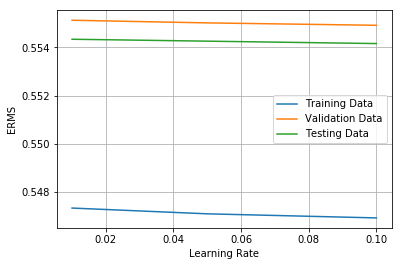

In [58]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, ErmsTR, label='Training Data')
line2, = ax.plot(learningRate, ErmsVal, label='Validation Data')
line3, = ax.plot(learningRate, ErmsTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('ERMS')
ax.grid(True)
ax.legend()
plt.show()

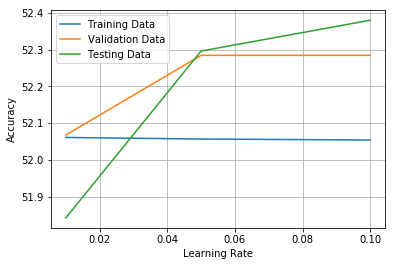

In [59]:
fig, ax = plt.subplots()
line1, = ax.plot(learningRate, AccTR, label='Training Data')
line2, = ax.plot(learningRate, AccVal, label='Validation Data')
line3, = ax.plot(learningRate, AccTest, label='Testing Data')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show()

Logistic Regression

In [ ]:
x_model, x_rest, y_model, y_rest = train_test_split(final_feature_cat, final_target, test_size=0.93, random_state=78)

# check for equal split
count = 0
for i in range(len(y_model)):
    if y_model[i] == 0:
        count = count + 1
print(count)
x_model.shape

x_trainR, x_testR, y_trainR, y_testR = train_test_split(x_model, y_model, test_size=0.1, random_state=1)
x_trainR, x_valR, y_trainR, y_valR = train_test_split(x_trainR, y_trainR, test_size=0.111, random_state=1)

x_trainR.shape

In [ ]:
all_W = one_vs_all(x_trainR, y_trainR, 1021, 1)
y_pred = predict_all(x_trainR, all_W)
y_pred.shape

In [ ]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_trainR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for training = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_testR, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_testR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for testing = {0}%'.format(accuracy * 100))

y_pred = predict_all(x_valR, all_W)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_valR)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy for validation = {0}%'.format(accuracy * 100))

Neural Network

In [285]:
input_size = 1021
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer_nodes = 2

model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               523264    
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total params: 524,290
Trainable params: 524,290
Non-trainable params: 0
_________________________________________________________________


In [286]:
x_model, x_rest, y_model, y_rest = train_test_split(final_feature_cat, final_target, test_size=0.9, random_state=78)

x_model.shape

(14306, 1021)

In [287]:
count = 0
for i in range(len(y_model)):
    if y_model[i] == 0:
        count = count + 1
count

7053

In [288]:
validation_data_split = 0.2
num_epochs = 100
model_batch_size = 256
tb_batch_size = 128
early_patience = 90

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

processedData = x_model
processedLabel = to_categorical(y_model)

processedLabel.shape



(14306, 2)

In [289]:
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 11444 samples, validate on 2862 samples
Epoch 1/100
11444/11444 [==============================] - 26s 2ms/step - loss: 0.9077 - acc: 0.5413 - val_loss: 0.6675 - val_acc: 0.5653
Epoch 2/100
11444/11444 [==============================] - 26s 2ms/step - loss: 0.6168 - acc: 0.6742 - val_loss: 0.5470 - val_acc: 0.7488
Epoch 3/100
11444/11444 [==============================] - 24s 2ms/step - loss: 0.5318 - acc: 0.7351 - val_loss: 0.5035 - val_acc: 0.7628
Epoch 4/100
11444/11444 [==============================] - 22s 2ms/step - loss: 0.4800 - acc: 0.7782 - val_loss: 0.4755 - val_acc: 0.7820
Epoch 5/100
11444/11444 [==============================] - 24s 2ms/step - loss: 0.4241 - acc: 0.8239 - val_loss: 0.5434 - val_acc: 0.7236
Epoch 6/100
11444/11444 [==============================] - 27s 2ms/step - loss: 0.3910 - acc: 0.8279 - val_loss: 0.4386 - val_acc: 0.8043
Epoch 7/100
11444/11444 [==============================] - 26s 2ms/step - loss: 0.3501 - acc: 0.8572 - val_loss: 0.4222 - v

11444/11444 [==============================] - 24s 2ms/step - loss: 0.0992 - acc: 0.9835 - val_loss: 0.5495 - val_acc: 0.8480
Epoch 60/100
11444/11444 [==============================] - 25s 2ms/step - loss: 7.0927e-04 - acc: 1.0000 - val_loss: 0.6369 - val_acc: 0.8428
Epoch 61/100
11444/11444 [==============================] - 26s 2ms/step - loss: 0.1256 - acc: 0.9851 - val_loss: 0.5923 - val_acc: 0.8452
Epoch 62/100
11444/11444 [==============================] - 24s 2ms/step - loss: 5.3765e-04 - acc: 1.0000 - val_loss: 0.6450 - val_acc: 0.8452
Epoch 63/100
11444/11444 [==============================] - 25s 2ms/step - loss: 0.1332 - acc: 0.9870 - val_loss: 0.6002 - val_acc: 0.8424
Epoch 64/100
11444/11444 [==============================] - 26s 2ms/step - loss: 5.2311e-04 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.8463
Epoch 65/100
11444/11444 [==============================] - 25s 2ms/step - loss: 0.1137 - acc: 0.9835 - val_loss: 0.6105 - val_acc: 0.8445
Epoch 66/100
11444/11444 [==

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3823d080>,
      dtype=object)

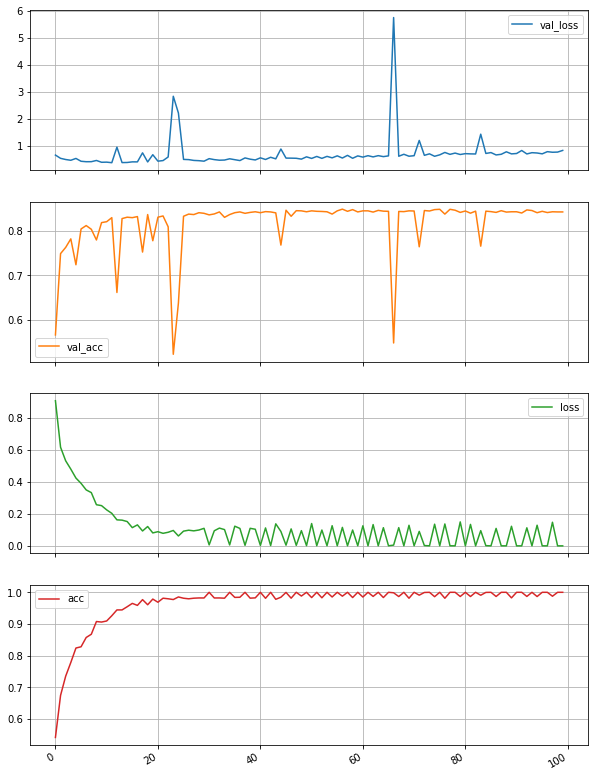

In [290]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [292]:
right = 0
wrong = 0
predictedTestLabel = []
for i,j in zip(x_model,y_model):
    y = model.predict(np.array(i).reshape(-1,input_size))
    predictedTestLabel.append(y.round())
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1 
print("Testing Accuracy: " + str(right/(right+wrong)*100))

Testing Accuracy: 48.50412414371592
